In [1]:
# Task
# https://www.hackerrank.com/challenges/document-classification/problem

# Useful links
# https://scikit-learn.org/stable/auto_examples/text/plot_document_classification_20newsgroups.html#sphx-glr-auto-examples-text-plot-document-classification-20newsgroups-py
# https://www.docsumo.com/blog/document-classification

# !/bin/python3

import math
import os
import random
import re
import sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [92]:
# Settings
nrFeatures = 150 # If the text is too short it won't have enough features, maybe can set rest to 0?

In [93]:
with open("trainingdata.txt", "r") as file1:
    content = file1.readlines()

N = content[0] # Training data size
del content[0] # Remove from read data   

In [94]:
# !pip uninstall scikit-learn

In [95]:
# !pip install scikit-learn==1.2.2 
# 1.3 version throws an error when trying to oversample
# !pip install nltk

In [96]:
import nltk # natural language processing
nltk.download('punkt')
nltk.download('wordnet')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\00350974\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\00350974\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [97]:
# !pip install imblearn

In [98]:
# Move the data into X (feature matrix) and y (class array)

from nltk.tokenize import sent_tokenize #word_tokenize or sent_tokenize (best for longer texts)

from nltk.stem import PorterStemmer
stemmer = PorterStemmer() # Reduces the words to their base form

from nltk.stem import WordNetLemmatizer
lemmatizer = WordNetLemmatizer() # Reduces inflection from words - similar to stemming
y = []
X = []
for line in content:
    y.append(int(line[0]))
    processed_line = sent_tokenize(line[2:]) # Tokenize the words. Other preprocesses include stop word removal, POS tagging and chunking
#     processed_line = [stemmer.stem(i) for i in processed_line] # Takes long time, use if needed
    processed_line = [lemmatizer.lemmatize(i) for i in processed_line] 
    X.append(processed_line[0])

df = pd.DataFrame(zip(X, y),
           columns =['Text', 'Class'])


In [99]:
print(len(df[df["Class"] == 1])) 
print(len(df[df["Class"] == 2]))
print(len(df[df["Class"] == 3])) 
print(len(df[df["Class"] == 4]))
print(len(df[df["Class"] == 5])) 
print(len(df[df["Class"] == 6]))
print(len(df[df["Class"] == 7])) 
print(len(df[df["Class"] == 8]))


2840
1596
251
108
41
253
190
206


In [100]:
df.head()

,Text,Class
0,champion products ch approves stock split cham...,1
1,computer terminal systems cpml completes sale ...,2
2,cobanco inc cbco year net shr cts vs dlrs net ...,1
3,am international inc am nd qtr jan oper shr lo...,1
4,brown forman inc bfd th qtr net shr one dlr vs...,1


In [101]:
# # Visualize the words with a word cloud
# # !pip install WordCloud
# import wordcloud
# wordcloud_pos = wordcloud(width=200,
#                          height=500,
#                          max_font_size=150).generate(print(df[df['Class'] == 1]))

# plt.figure(figsize=(15, 10))
# plt.imshow(interpolation = "bilinear")
# plt.axis("off")
# plt.title(f"Most common words associated with non-toxic comment", size=20)
# plt.show()

In [102]:
from sklearn.preprocessing import MinMaxScaler, Normalizer 
from sklearn.feature_extraction.text import TfidfVectorizer # term frequency
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
import warnings
warnings.filterwarnings('ignore')


In [103]:
# X_train, X_test, y_train, y_test = train_test_split(df["Text"], df["Class"], test_size=0.10)
X_train, X_test, y_train, y_test = train_test_split(df["Text"], df["Class"], test_size=0.10)

# https://realpython.com/python-keras-text-classification/

# - Bag Of Words -
# Create features from the data
tfidf = TfidfVectorizer(lowercase=False, max_features=nrFeatures, stop_words ="english")  # term frequency
X_train_tfidf = tfidf.fit_transform(X_train).toarray()
X_test_tfidf = tfidf.transform(X_test).toarray()

# Normalize the vectors - probably not needed
norm_TFIDF = Normalizer(copy=False)
X_norm_train_tfidf = norm_TFIDF.fit_transform(X_train_tfidf)
X_norm_test_tfidf = norm_TFIDF.transform(X_test_tfidf)

In [104]:
# from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import RandomOverSampler

# Oversample the data to improve classification for classes with less items
def oversample_dataset(X, y):
    ros = RandomOverSampler()
    X_os,y_os = ros.fit_resample(X,y) # Take more of the class with fewer items until they have the same amount

    # Below is what we want to do - have to reshape y first to 2D
#     data = np.hstack((X, y)) # horisontal stack
    data = np.hstack((X_os, np.reshape(y_os, (-1, 1)))) # horisontal stack. (-1, 1) gets evaluated as (len(y), 1)

    return data, X_os, y_os

In [105]:
# Over sample the data to improve the training. Before, there were 100 times more data of class 1 than class 5
y_train = y_train.to_numpy()
y_test = y_test.to_numpy()
_, X_norm_train_tfidf_os, y_train_os = oversample_dataset(X_norm_train_tfidf,y_train)
_, X_norm_test_tfidf_os, y_test_os = oversample_dataset(X_norm_test_tfidf,y_test)

In [106]:
print(len(y_os[y_os==1]))
print(len(y_os[y_os==8]))
print(len(X_norm_train_tfidf_os))

2840
2840
20352


In [109]:
df.head()

,Text,Class
0,champion products ch approves stock split cham...,1
1,computer terminal systems cpml completes sale ...,2
2,cobanco inc cbco year net shr cts vs dlrs net ...,1
3,am international inc am nd qtr jan oper shr lo...,1
4,brown forman inc bfd th qtr net shr one dlr vs...,1


In [134]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, roc_curve, precision_recall_curve

knn_model = KNeighborsClassifier(n_neighbors=5)
knn_model.fit(X_norm_train_tfidf_os, y_train_os)
y_pred = knn_model.predict(X_norm_test_tfidf_os)

              precision    recall  f1-score   support

           1       0.99      0.96      0.97       296
           2       0.71      0.91      0.80       296
           3       0.60      0.84      0.70       296
           4       0.78      0.52      0.63       296
           5       0.63      0.21      0.32       296
           6       0.85      0.89      0.87       296
           7       0.70      0.92      0.79       296
           8       0.80      0.80      0.80       296

    accuracy                           0.76      2368
   macro avg       0.76      0.76      0.73      2368
weighted avg       0.76      0.76      0.73      2368



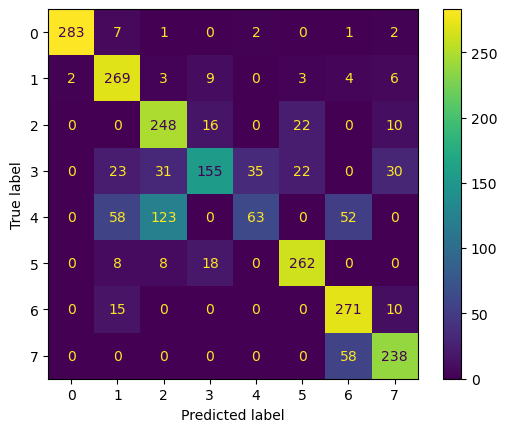

In [135]:
print(classification_report(y_test_os, y_pred))
cm = confusion_matrix(y_test_os, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
plt.show()

In [136]:
from sklearn.naive_bayes import GaussianNB
nb_model = GaussianNB()
nb_model.fit(X_norm_train_tfidf_os, y_train_os)
y_pred = nb_model.predict(X_norm_test_tfidf_os)

              precision    recall  f1-score   support

           1       0.88      0.94      0.91       296
           2       0.83      0.80      0.81       296
           3       0.57      0.45      0.50       296
           4       0.57      0.64      0.60       296
           5       0.58      0.81      0.68       296
           6       0.74      0.74      0.74       296
           7       0.60      0.61      0.61       296
           8       0.68      0.45      0.54       296

    accuracy                           0.68      2368
   macro avg       0.68      0.68      0.67      2368
weighted avg       0.68      0.68      0.67      2368



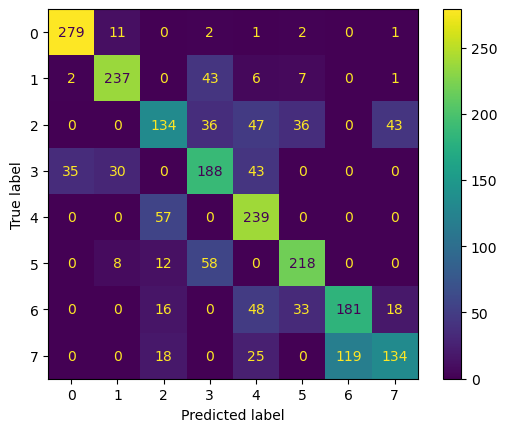

In [137]:
print(classification_report(y_test_os, y_pred))
cm = confusion_matrix(y_test_os, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
plt.show()

In [138]:
from sklearn.svm import SVC # Support vector classifier
svm_model = SVC()
svm_model.fit(X_norm_train_tfidf_os, y_train_os)
y_pred = svm_model.predict(X_norm_test_tfidf_os)

              precision    recall  f1-score   support

           1       0.81      0.98      0.89       296
           2       0.69      0.97      0.80       296
           3       0.79      0.93      0.85       296
           4       0.49      0.64      0.56       296
           5       0.00      0.00      0.00       296
           6       0.86      0.91      0.89       296
           7       0.87      0.92      0.89       296
           8       0.95      0.75      0.84       296

    accuracy                           0.76      2368
   macro avg       0.68      0.76      0.72      2368
weighted avg       0.68      0.76      0.72      2368



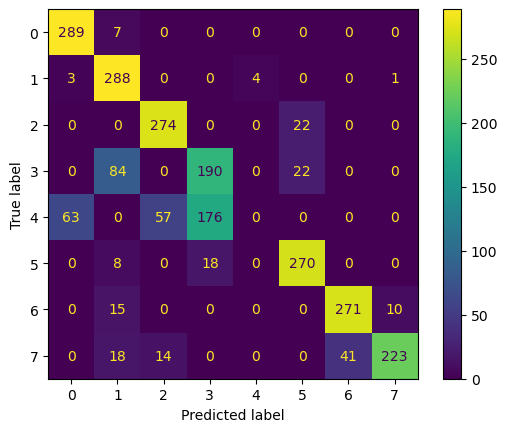

In [139]:
print(classification_report(y_test_os, y_pred))
cm = confusion_matrix(y_test_os, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
plt.show()

In [140]:
ml_model = svm_model

# CLASSIFY AN INPUT

**Manually paste from training data**

In [120]:

warnings.filterwarnings('ignore')
# Read input from stdio
#     input = sys.stdin.readline
nrClassifications = 1 #int(input()) # first line says how many more lines there are

for i in range(nrClassifications):
    line = input()

    stemmer = PorterStemmer() # Reduces the words to their base form
    lemmatizer = WordNetLemmatizer() # Reduces inflection from words - similar to stemming

    processed_line = sent_tokenize(line) # Tokenize the words. Other preprocesses include stop word removal, POS tagging and chunking
#     processed_line = [stemmer.stem(i) for i in processed_line] # Takes long time, use if needed
    processed_line = [lemmatizer.lemmatize(i) for i in processed_line] 
#         X.append(processed_line[0])
    X = processed_line

    # Create features from the data
    tfidf_in = TfidfVectorizer(lowercase=False, max_features=nrFeatures, stop_words ="english")  # term frequency, can remove stop words here
    X_ft_tfidf = tfidf_in.fit_transform(X).toarray()

    # Normalize the vectors
    norm_TFIDF = Normalizer(copy=False)
    X_ft_norm_tfidf = norm_TFIDF.fit_transform(X_ft_tfidf)

    # Create a vector of zeros with the same number of features as the model's training data
    X_norm_input_tfidf = np.zeros([1, nrFeatures])

    feature_names_input = tfidf_in.get_feature_names_out()
    matched_feature_names = []

    # Check whether each feature in the input is in the trained features list
    for i in range(len(feature_names_input)):
        feat_input = feature_names_input[i]

        for j in range(len(feature_names)):
            feat = feature_names[j]

            if feat_input == feat:
                X_norm_input_tfidf[0,j] = X_ft_norm_tfidf[0,i]
                matched_feature_names.append(feat_input)
                continue   # Skip to next 

    print("Class is: ", ml_model.predict(X_norm_input_tfidf)[0])



london grain freights wheat ria luna mt norrkoping and djuron ec mexico dlrs option loading uddevalla at cents less continental reference new york grain freights of march brokers say the charterer of the saturn from us gulf to japan is reported to be nordstrom and thulin while the antigone is reported to have been arranged from tilbury to the black sea by soviet charterers reuter 
Class is:  2


In [117]:
print(X_norm_input_tfidf)
print(X_ft_norm_tfidf)
print(matched_feature_names)

[[0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.14586499 0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.14586499 0.         0.         0.14586499 0.         0.
  0.         0.         0.         0.         0.14586499 0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.14586499 0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.   